In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from PIL import Image

In [37]:
from game_assets.utils import simplify_image, save_img
from conv_rgb.model import ConvRGB

In [38]:
from pysimulacra.data import SimulacraData

ds = SimulacraData('../raw_data/sac_public_2022_06_29.sqlite')

# data = ds.fetch_all_data()

In [39]:
'raw_data/sac-000000'

'raw_data/sac-000000'

In [40]:
# 'simulacra-aesthetic-captions'

In [41]:
# img_df = ds.get_image_paths_and_prompts()

In [42]:
img_df = ds.get_image_paths_and_prompts_and_ratings()
img_df

,img_id,img_prompt,img_path,img_rating
0,1,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,7
1,1,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,1
2,6,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,4
3,5,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,6
4,4,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,6
...,...,...,...,...
176934,248438,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,5
176935,248439,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,7
176936,248440,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,6
176937,248441,avatar of a dragon knight anato finnstark yosi...,43044_avatar_of_a_dragon_knight_anato_finnstar...,5


In [67]:
def square_image(pil_img):
    
    width, height = pil_img.size # Get dimensions
    
    if width < height:
        new_width, new_height = width, width
    else:
        new_width, new_height = height, height
        
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = pil_img.crop((left, top, right, bottom))
    
    return im

In [68]:
def simplify_image(pil_img, num_colors = 8, size = (256, 256)):

    img = pil_img.quantize(colors=num_colors, method=2)
    
    sq_img = square_image(img).resize(size, Image.LANCZOS)
    
    return sq_img

def add_border(old_img, width = 6):
    img_arr = np.array(old_img)

    old_size = old_img.size
    
    new_size = [size + width for size in old_size]

    #new_size = (800, 800)
    new_img = Image.new("RGB", new_size, 'White')
    box = tuple((n - o) // 2 for n, o in zip(new_size, old_size))
    new_img.paste(old_img, box)
    
    return new_img

In [43]:
def shorten_path(img_path):
    name_parts = img_path.split('_')
    new_name = f'{name_parts[0]}_{name_parts[-1]}'
    return new_name

In [44]:
img_df['short_img_path'] = img_df.img_path.apply(shorten_path)

In [45]:
import regex as re
import string

def clean_png_path(file_name):
    
    file_name = file_name.replace(',', ' ')
    
    #suffix = file_name[-4:]
    
    clean_file_name = re.sub(r'[^A-Za-z0-9 ]+', '', file_name)
    
    return '_'.join(clean_file_name.split()) #+ suffix


In [46]:
img_df['clean_prompt'] = img_df.img_prompt.apply(clean_png_path)

In [47]:
# https://github.com/google-research-datasets/conceptual-captions/blob/master/LICENSE
# https://ai.google.com/research/ConceptualCaptions/download

# data = pd.read_csv('../raw_data/Validation_GCC-1.1.0-Validation.tsv', sep = '\t', header = None)
# data.columns = ['caption', 'url']

In [48]:
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device) # "ViT-B/32"


def clip_encode_image(pil_img):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    image = preprocess(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)

    return image_features


In [619]:
colour_model = ConvRGB(input_shape = (240, 240), n_cut = 8)

In [632]:
import matplotlib.pyplot as plt

def colours_as_pct(input_images):
#     print(np.min(input_images))
    images = np.add(np.ones(input_images.shape), input_images)
#   images = images + 1 # avoid dividing by zero
#     if np.min(images) == '0':
#     print('min:',  np.min(images))
#     print(type(images))
#     print(images)
#     plt.imshow(images[0] / 255)
#     plt.show()
        
#     images = np.true_divide(images, images.sum(axis=-1, keepdims=True))
    
    images = images / images.sum(axis=-1, keepdims=True)
    return images

In [633]:
def colour_encode_image(pil_img):
    
    img = pil_img.resize((240, 240))
    
    X = np.expand_dims(np.array(img), axis = 0)
    
    X = colours_as_pct(X)
    
    colour_features = colour_model(X)
    
    return colour_features

In [677]:
os.listdir('../raw_data/sac-000000/')

['25308_2.png',
 '13941_1.png',
 '26058_1.png',
 '38376_1.png',
 '1280_4.png',
 '16742_2.png',
 '7322_7.png',
 '10188_1.png',
 '13474_3.png',
 '8254_4.png',
 '15654_6.png',
 '8440_5.png',
 '16996_5.png',
 '7278_5.png',
 '31379_2.png',
 '5478_7.png',
 '9110_4.png',
 '5732_8.png',
 '31472_1.png',
 '42288_1.png',
 '20593_2.png',
 '1063_6.png',
 '17664_4.png',
 '41840_4.png',
 '18791_1.png',
 '5147_8.png',
 '33932_1.png',
 '16508_8.png',
 '3151_3.png',
 '30198_2.png',
 '36326_4.png',
 '18636_3.png',
 '16371_5.png',
 '23585_3.png',
 '38647_1.png',
 '32540_4.png',
 '27630_4.png',
 '37416_1.png',
 '19900_6.png',
 '9093_7.png',
 '28033_2.png',
 '26668_1.png',
 '6980_7.png',
 '12380_2.png',
 '10434_8.png',
 '22808_1.png',
 '11427_2.png',
 '36358_2.png',
 '38687_1.png',
 '13963_6.png',
 '8661_5.png',
 '5954_4.png',
 '409_4.png',
 '23870_1.png',
 '6509_4.png',
 '37792_1.png',
 '6650_1.png',
 '5275_7.png',
 '27165_4.png',
 '32215_4.png',
 '35419_1.png',
 '8434_8.png',
 '18002_7.png',
 '5662_1.png'

In [832]:
def qcolour_encode_image(pil_img):
    
    q_img = pil_img.quantize(colors=256, method=2)
    
    
    features = np.unique(np.array(p_img), return_counts = True)[1]
    
    return features
    

In [839]:
def qcolour_encode_image(pil_img):
    
    q_img = pil_img.quantize(colors=8, method=2)
    
    q_img = q_img.convert('RGB')
    
    p_img = q_img.convert('P')

    colcounts = np.unique(np.array(p_img), return_counts = True)

    features = np.zeros((256))

    for i in range(len(colcounts[0])):

        idx = colcounts[0][i]

        count = colcounts[1][i]

        features[idx] = count
    
    return features


In [878]:
timg = Image.open('../raw_data/sac-000000/5954_4.png') #  6650_1

# q_img = timg.quantize(colors=8, method=2)
    
# q_img = q_img.convert('RGB')
    
p_img = timg.convert('P')

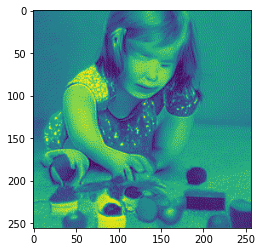

In [887]:
plt.imshow(np.array(p_img))

In [881]:
palette = np.array(p_img.getpalette(),dtype=np.uint8).reshape((256,3))
palette

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [ 51,   0,   0],
       [102,   0,   0],
       [153,   0,   0],
       [204,   0,   0],
       [255,   0,   0],
       [  0,  51,   0],
       [ 51,  51,   0],
       [102,  51,   0],
       [153,  51,   0],
       [204,  51,   0],
       [255,  51,   0],
       [  0, 102,   0],
       [ 51, 102,   0],
       [102, 102,   0],
       [153, 102,   0],
       [204, 102,   0],
       [255, 102,   0],
       [  0, 153,   0],
       [ 51, 153,   0],
       [102, 153,   0],
       [153, 153,   0],
       [204, 153,   0],
       [255, 153,   0],
       [  0, 204,   0],
       [ 51, 204,   0],
       [102, 204,   0],
       [153, 204,   0],
       [204, 204,   0],
       [255, 204,   0],
       [  0, 255,   0],
       [ 51, 255

In [ ]:
# Convert Image to RGB and make into Numpy array
na = np.array(im.convert('RGB')) 

# Get used colours and counts of each
colours, counts = np.unique(na.reshape(-1,3), axis=0, return_counts=1) 

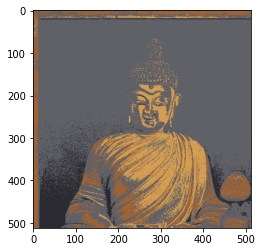

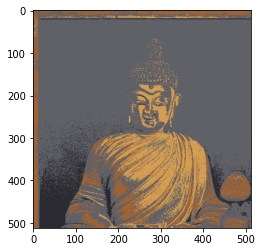

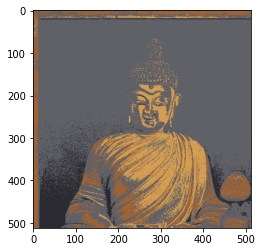

(array([0, 1, 2, 3], dtype=uint8), array([185670,  31460,  27370,  17644]))


In [856]:
q_img = timg.quantize(colors = 4, method=2)

plt.imshow(q_img)
plt.show()

#q_img = q_img.convert('RGB')

plt.imshow(q_img)
plt.show()

# colcounts = np.unique(np.array(q_img), return_counts = True)

# print(colcounts)


p_img = q_img.convert('P')

plt.imshow(p_img)
plt.show()

colcounts = np.unique(np.array(p_img), return_counts = True)

print(colcounts)

features = np.zeros((256))

for i in range(len(colcounts[0])):

    idx = colcounts[0][i]

    count = colcounts[1][i]

    features[idx] = count

In [854]:
features

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 5.00000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 4.20000e+01, 1.83000e+02, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       1.49000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 9.03000e+02, 2.98100e+03, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 2.55500e+03, 1.09300e+04, 0.00000e+00,
       4.60000e+01, 4.11000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       3.61000e+02, 2.50860e+04, 1.36500e+03, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 7.12400e+03, 2.359

In [808]:
len(colcounts[0])

57

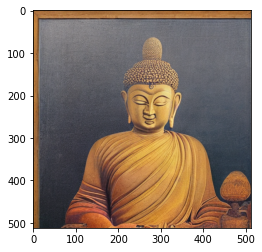

In [840]:
plt.imshow(timg)

In [841]:
qcolour_encode_image(timg)

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 7.10000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 2.40000e+01, 3.23000e+02, 6.27000e+02, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       1.85000e+02, 4.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 5.29000e+02, 2.47200e+03, 2.80000e+01, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 2.24900e+03, 2.11570e+04, 6.91000e+03,
       7.00000e+00, 2.91000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       3.02000e+02, 3.45350e+04, 2.35100e+03, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 1.65900e+03, 7.44000e+03, 2.522

In [776]:
import os
all_imgs = os.listdir('../raw_data/sac-000000/')

In [777]:
exist_df = pd.DataFrame({'short_img_path': pd.Series(all_imgs)})

In [636]:
len(pd.Series(all_imgs)), len(pd.Series(all_imgs).unique())

(2259, 2259)

In [637]:
df = exist_df.merge(img_df, how = 'inner').drop_duplicates()

In [638]:
df_loop = df.sort_values('img_rating', ascending = False)[:1000]

In [639]:
# df_loop

In [640]:
!mkdir ../raw_data/sac_images2

mkdir: ../raw_data/sac_images2: File exists


In [842]:
#clip_features_list = []
colour_features_list = []
#image_path_list = []

for i, row in tqdm(df_loop.iterrows()):
    
    img_path, caption = row['short_img_path'], row['clean_prompt']
    
    if img_path.endswith('png'):

        img = Image.open(f'../raw_data/sac-000000/{img_path}')

        if img:
            
            #img = colours_as_pct(img)

            #clip_features_list.append(clip_encode_image(img)[0])
            #colour_features_list.append(colour_encode_image(img)[0])
            colour_features_list.append(qcolour_encode_image(img))
            
            
            #simple_img = simplify_image(img, num_colors = 256)
            
            #simple_img = add_border(simple_img, width = 8)

            #save_img(simple_img, caption, destination_folder = '../raw_data/sac_images3')

            #image_path_list.append(f"{caption}.png")
#     if len(features_list) % 10 == 0:
#         print(len(features_list))
        
        

#image = get_simplified_image(url, caption, destination_folder = '../raw_data/images', num_colors = 256)

1000it [00:27, 36.84it/s]


In [843]:
image_embeddings = np.stack(clip_features_list)
colour_embeddings = np.stack(colour_features_list)


In [844]:
image_embeddings[:947].shape

(947, 768)

In [845]:
colour_embeddings[:947].shape

(947, 256)

In [846]:
# the embeddings and img list are not the same length because of the loop failure point
# need to drop one extra img/embed

In [847]:
from sklearn.preprocessing import StandardScaler

s_image_embeddings = StandardScaler().fit_transform(image_embeddings[:947])

s_colour_embeddings = StandardScaler().fit_transform(colour_embeddings[:947])

In [192]:
np.stack([image_embeddings, colour_embeddings], axis = 0)

ValueError: all input arrays must have the same shape

In [716]:
img_array_list = [np.array(Image.open(f'../raw_data/sac_images2/{image_path}'))/255 for image_path in image_path_list]

In [613]:
len(img_array_list)

947

In [173]:
# X_image_embeddings = torch.from_numpy(image_embeddings)
# X_image_embeddings.shape

torch.Size([948, 768])

In [ ]:
colour_embeddings[:948]

In [174]:
# mnist = pymde.datasets.MNIST()
# mnist.data

In [848]:
import pymde

image_mde = pymde.preserve_neighbors(s_image_embeddings, embedding_dim=2)
mde_image_2d = image_mde.embed()


colour_mde = pymde.preserve_neighbors(s_colour_embeddings, embedding_dim=2)
mde_colour_2d = colour_mde.embed()

Aug 19 04:56:49 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Aug 19 04:56:49 PM: The following items have duplicates [  5   7  18  28  33  37  55  69  76  81  91  94  95 100 107 126 129 165
 185 193 218 232 262 294 295 297 348 371 373 384 385 407 438 451 462 465
 470 483 488 519 526 534 544 568 581 604 640 663 665 687 690 703 709 751
 809 810 822 823 858 871 914 916 920 931 942]
Aug 19 04:56:50 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Aug 19 04:56:50 PM: The following items have duplicates [  4  34  47  59  76  81 107 110 118 126 139 148 152 161 165 166 181 182
 192 193 228 232 254 255 258 276 294 307 347 348 373 384 400 407 409 425
 427 464 467 470 501 515 533 544 558 581 621 624 635 665 674 677 690 727
 737 749 755 759 794 799 819 822 838 849 858 914 920]


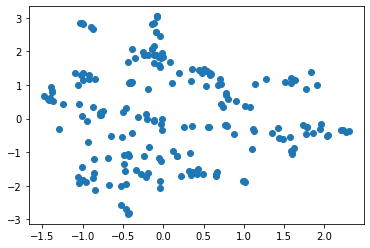

In [592]:
import matplotlib.pyplot as plt
plt.scatter(mde_image_2d[-200:, 0], mde_image_2d[-200:, 1])

In [467]:
from umap import UMAP

umap_image_2d = UMAP().fit_transform(s_image_embeddings)
umap_colour_2d = UMAP().fit_transform(s_colour_embeddings)

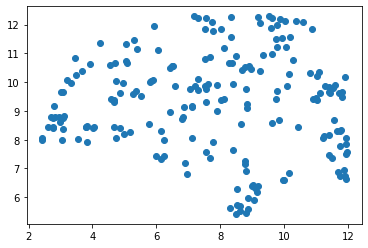

In [468]:
import matplotlib.pyplot as plt
plt.scatter(umap_colour_2d[-200:, 0], umap_colour_2d[-200:, 1])

In [267]:
np.isnan(s_colour_embeddings).sum()

0

In [568]:
# create and fit a 2d PCA
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(s_image_embeddings)

pca.explained_variance_

# actually project only PC's
pca_image_2d = pca.transform(s_image_embeddings)

In [509]:
s_colour_embeddings.shape

(947, 1452)

In [849]:
pca = PCA(2)
pca_colour_2d = pca.fit_transform(s_colour_embeddings)

# actually project only PC's
# pca.transform(mde_colour_2d)

In [827]:
pca.explained_variance_

array([14.89984345,  8.9685702 ])

In [719]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize
from tqdm import tqdm
import numpy as np
from PIL import Image

def show_xy_images(x_coords, y_coords, img_arr_list, image_zoom=1):
    fig, ax = plt.subplots(1,1, figsize=(16, 16))
    artists = []
    for x_coord, y_coord, img in tqdm(zip(x_coords, y_coords, img_arr_list)):
        c_img = resize(img, [50,50])
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (x_coord, y_coord),
                            xycoords='data',
                            frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.stack([x_coords, y_coords], axis=1))
    ax.autoscale()

In [562]:
pca_colour_2d

array([[ -2.836201  ,   0.31395307,  -1.027124  ,   0.77738744,
          0.16807874],
       [ -6.954053  ,   3.064603  ,  -1.0836805 ,  -3.1122801 ,
         -1.6192237 ],
       [  5.786526  ,  -8.071698  ,  -2.4053302 ,  -3.1687555 ,
         -2.6744366 ],
       ...,
       [ -3.5568185 , -13.727792  ,  -2.8936286 ,   0.6489706 ,
          2.8088913 ],
       [  3.7692275 ,  -3.5146117 ,   0.3397475 ,   1.2639722 ,
          1.9446558 ],
       [ 20.345531  , -17.561148  ,  -1.187094  ,   0.40142804,
          6.9195247 ]], dtype=float32)

In [ ]:
# including convert to pct is important
# include both?

In [555]:
len(pca_colour_2d), len(img_array_list)

(947, 947)

200it [00:00, 807.88it/s]


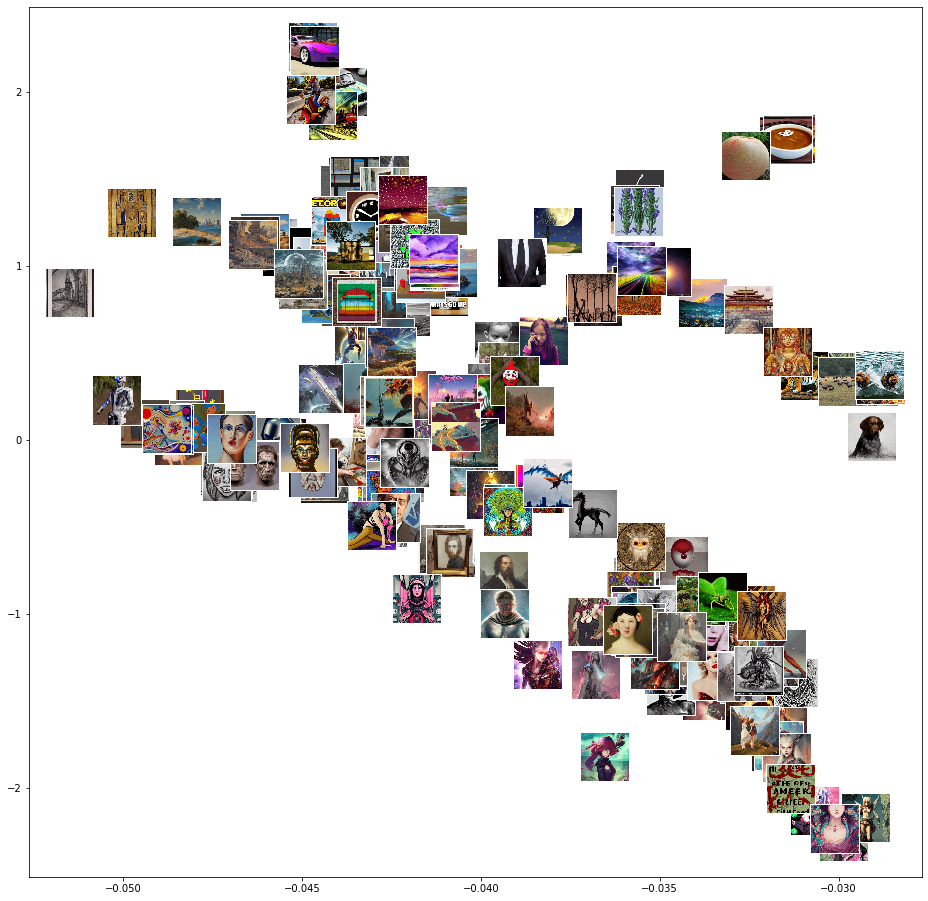

In [572]:
show_xy_images(x_coords = mde_image_2d[-200:, 0], 
               y_coords = mde_image_2d[-200:, 1], 
               img_arr_list = img_array_list[-200:])


200it [00:00, 980.09it/s]


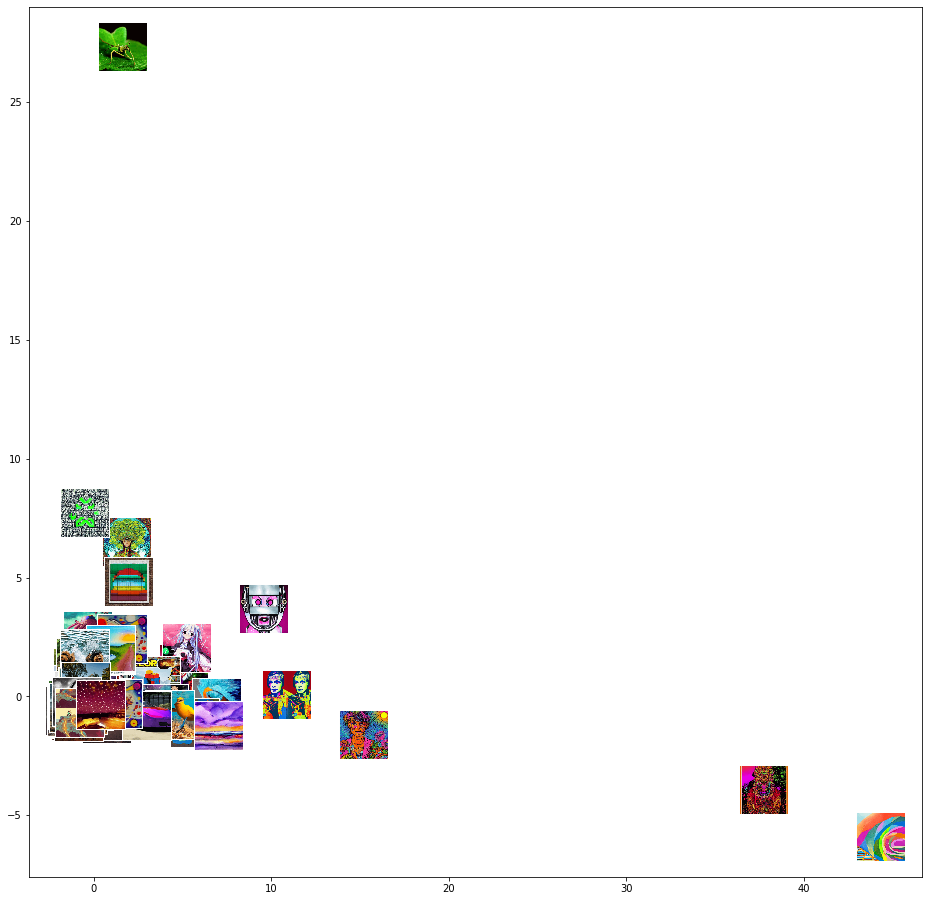

In [851]:
show_xy_images(x_coords = pca_colour_2d[-200:, 0], 
               y_coords = pca_colour_2d[-200:, 1], 
               img_arr_list = img_array_list[-200:])

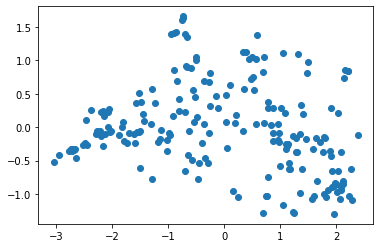

In [194]:
import matplotlib.pyplot as plt
plt.scatter(colour_2d[-200:, 0], colour_2d[-200:, 1])

In [195]:
# np.argwhere(embedding[:, 0] < -2)

In [196]:
# df_loop.iloc[[  9, 152, 207, 211, 342, 643], :]

In [201]:
!mkdir ../raw_data/sac_images_subset/

In [202]:
!ls ../raw_data

Validation_GCC-1.1.0-Validation.tsv latent_space_map.json
artist_images                       mj_background
artist_images_semisimple            mj_background.png
artist_images_simple                pad_background_100.png
images                              pad_background_100_256bit.png
images2                             sac-000000
images_simple                       sac_images
latent_space_background_256bit.png  sac_images_subset
latent_space_background_32bit.png   sac_public_2022_06_29.sqlite
latent_space_background_8bit.png


In [437]:
!mkdir ../raw_data/sac_images_subset2

In [438]:
import shutil

for path in image_path_list[-200:]:
    shutil.copy2(f'../raw_data/sac_images2/{path}', f'../raw_data/sac_images_subset2/{path}')

In [439]:
def embedding_to_coords(embedding, coord, scale = 1000):
    
    if coord == 'X':
        col = 0
    elif coord == 'Y':
        col = 1
    else:
        print("coord must be X or Y")
    
    coords = embedding.numpy()[:, col]
    
    print(coords)

    from_one = coords - min(coords)
    
    print(from_one)

    return [int(coord) for coord in (from_one / max(from_one) * scale)]

In [440]:
clean_png_path('author : a life in photography -- in pictures.png')

'author_a_life_in_photography_in_picturespng'

In [441]:
clean_image_path_list = [clean_png_path(path) for path in image_path_list]

In [213]:
embedding_to_coords(image_2d[-200:], 'X', scale = 1)

[ 0.6301441   0.36839834  1.8447255  -0.08925921  2.267181   -1.4735893
  0.33284163 -0.38114482  1.156299   -1.735236    1.8602356  -0.44984886
 -0.23178656 -0.89783674 -1.2211554  -1.5096049   0.06701159  2.1200945
 -0.2676938   0.25411943  0.607149    0.01104164 -0.26359898 -0.02182177
 -1.5083299   0.381817   -0.10824201  0.5413361   0.6135507  -0.8111511
 -0.41066974 -1.6682907   0.29719138 -0.90579623 -0.25047648 -0.18802346
  0.93212926 -0.09519415 -1.8427622   0.08513659 -0.02724191  0.7365371
  0.13840213 -1.5297585   1.1214162   0.9106823   1.7452544   0.27813894
 -0.28221816  0.621899    0.7862725  -1.4487085   1.030841   -0.8640677
  0.36993948 -1.4244267  -0.9146273  -0.31729805  0.8822071  -0.6819769
  0.36718476  0.9082412   0.5171608   0.3183227   0.66902256 -0.47737977
 -0.73971     0.21875836 -0.62259215 -0.7798246   1.1407903  -0.8125038
 -0.57473147 -1.7138908   0.74932885  0.2724867  -0.0943693   0.38478866
  0.92853916  0.8807121  -0.85664666  2.0512338   0.381873

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [442]:
# take 200 images with the highest rating
import json

X_image_coords = embedding_to_coords(mde_colour_2d[-200:], 'X', scale = 1000)
Y_image_coords = embedding_to_coords(mde_colour_2d[-200:], 'Y', scale = 1000)
X_colour_coords = embedding_to_coords(mde_colour_2d[-200:], 'X', scale = 1000)
Y_colour_coords = embedding_to_coords(mde_colour_2d[-200:], 'Y', scale = 1000)

map_json = {
    "X_image_coords": X_image_coords,
    "Y_image_coords": Y_image_coords,
    "X_colour_coords": X_colour_coords,
    "Y_colour_coords": Y_colour_coords,
    "image_paths": image_path_list[-200:]
}

with open('../raw_data/sac2_latent_space_map.json', 'w') as f:
    json.dump(map_json, f)


[ 0.68743026  2.7064683  -3.081813   -1.0904543   0.5710831  -0.11903058
  1.8028696   1.7718208  -1.1783092  -1.2252287  -2.7155046   2.4545631
  0.77503276  0.86383474  1.5890303  -1.9632629   1.5593814  -0.88548183
 -1.0511533  -2.4164078  -1.100153    1.9891427   1.7907712  -0.01889332
  1.8083799  -1.6843268   0.66792655  2.7155542   1.8735921   0.0107454
 -1.20233     0.67487544  0.48083693  1.8219982   0.645971    1.4740704
  1.9081781  -3.1090076  -1.8015195  -1.1978717   0.62558866 -2.0685208
 -1.8853871   0.39665657 -2.0020807   0.53800833 -1.9331704   1.4333328
  0.9321138  -2.7850385   2.4920619   3.0559323  -0.51582944 -2.4500678
 -0.32119012 -2.6075351   0.27498162  1.6079621   3.0150962  -0.09472415
 -0.5789019   3.0398498   0.80149955  0.6767649   2.8171678  -0.49634925
 -0.46952063  1.9932784   2.6695182  -0.51993734 -0.29900995 -1.4078058
 -0.48425442  1.9951668  -2.9238205  -2.8588054   0.772661    3.3250105
 -2.9110613  -2.9199438  -1.3824407  -3.0183425   0.0206206

In [443]:
map_json

{'X_image_coords': [599,
  906,
  27,
  329,
  582,
  477,
  768,
  764,
  316,
  309,
  83,
  867,
  612,
  626,
  736,
  197,
  732,
  360,
  335,
  128,
  328,
  797,
  767,
  492,
  769,
  239,
  596,
  907,
  779,
  497,
  312,
  597,
  568,
  771,
  593,
  719,
  784,
  23,
  221,
  313,
  590,
  181,
  209,
  555,
  191,
  577,
  201,
  712,
  636,
  72,
  873,
  959,
  417,
  123,
  446,
  99,
  537,
  739,
  952,
  480,
  407,
  956,
  617,
  598,
  922,
  420,
  424,
  797,
  900,
  416,
  449,
  281,
  421,
  798,
  51,
  61,
  612,
  1000,
  53,
  52,
  285,
  37,
  498,
  786,
  935,
  593,
  503,
  752,
  903,
  690,
  84,
  690,
  296,
  549,
  293,
  221,
  361,
  148,
  492,
  17,
  271,
  954,
  776,
  627,
  269,
  874,
  436,
  406,
  537,
  806,
  504,
  8,
  904,
  12,
  195,
  752,
  400,
  313,
  498,
  308,
  770,
  58,
  605,
  699,
  724,
  838,
  406,
  218,
  432,
  681,
  859,
  390,
  881,
  832,
  883,
  40,
  874,
  360,
  420,
  348,
  627,
  466,
  58

In [ ]:
# copy raw_data/sac_latent_space_map.json into the game assests folder

In [253]:
os.listdir('../raw_data/images')

['beverage_type_the_original_beer.png',
 'film_actor_attends_the_premiere_during_film_festival_and_festivals.png',
 'politicians_speaking_at_an_event.png',
 'man_carrying_pond_in_the_mountain.png',
 'leading_lady_actor_is_heading_up_the_cast_as_the_accused_woman_herself.png',
 'i_m_not_one_for_facial_piercings_but_i_must_say_that_fictional_character_can_be_really_beautiful.png',
 'fresh_green_forest_and_gentle_river_after_the_rain.png',
 'shoppers_struggle_through_the_heavy_snow.png',
 'person_feeding_apples_to_an_elephant_in_captivity.png',
 'the_tattoo_is_wrapped_in_cling_film_to_protect_it_for_the_first_night.png',
 'a_man_hiking_through_the_woods_looks_around_the_forest_and_then_smiles_at_the_camera_in_slow_motion.png',
 'cinematic_style_video_of_young_student_in_cafe.png',
 'hands_down_the_top_question_we_get_asked_is_how_to_achieve_a_consistent_style_in_your_home.png',
 'stylish_couple_actor_and_organisation_founder_put_on_a_loved_up_display_as_they_enjoyed_day_on_monday.png',
 '

In [249]:
### rename images

# import os

# directory_path = '../raw_data/images'

# for file_name in os.listdir(directory_path):
#     os.rename(f'{directory_path}/{file_name}', f'{directory_path}/{clean_png_path(file_name)}')

## Background

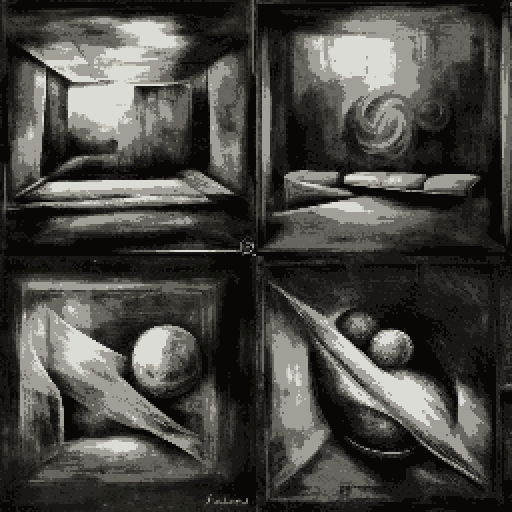

In [281]:
pil_img = Image.open('../raw_data/mj_background.png')
img = pil_img.quantize(colors=32, method=2).resize((256, 256), Image.LANCZOS).resize((512, 512), Image.LANCZOS)
img

In [282]:
img.save('../raw_data/latent_space_background_32bit.png')

In [62]:
# #!mkdir ../raw_data/images_simple

# pil_img = Image.open('../raw_data/latent_space_background_32bit.png')

# img = simplify_image(pil_img, num_colors = 8, size = (128, 128))

# # img.save('../raw_data/latent_space_background_256bit.png'

NameError: name 'img' is not defined

In [21]:
# !mkdir ../raw_data/artist_images_semisimple/

In [22]:
# import os
# from tqdm import tqdm
# for file_name in tqdm(os.listdir("../raw_data/artist_images")):
#     if file_name.endswith('.png'):
#         pil_img = Image.open(f"../raw_data/artist_images/{file_name}")
#         simp_img = simplify_image(pil_img, num_colors = 256, size = (240, 240))
#         border_img = add_border(simp_img, width = 8)
#         border_img.save(f"../raw_data/artist_images_semisimple/{file_name}")

100%|█████████████████████████████████████████| 480/480 [00:30<00:00, 15.62it/s]


### choose less images and reduce the scale of the json